# Prerequisites

### Know how to specifiy array elements using indexing (e.g. y[3], array[:,0])

### Know how to draw some basic plots with `matplotlib`

### Know how to make a simple animation with `matplotlib`

# Import required modules

In [1]:
%matplotlib notebook

import matplotlib.pyplot as plt

import numpy as np

# [ A particle in an infinite Potential Well ('box') ]

### Because $V(x)=\infty$ for $x<x_{min}$ and $x_{max}<x$
### $\psi(x_{min})=0$ and $\psi(x_{max})=0$

### Thus, we will only consider $\psi$ values at 'inside': from $x_{min}+\Delta{x}$ to $x_{max}-\Delta{x}$

# [ Configuration ]

## Set boundary condition

In [2]:
boundary = 'zero'

assert boundary in ['zero', 'periodic']

## Configure spatial grid

In [3]:
## Parameters for spatial grid (specified by 'x', in this 1D model)
N_x = 999   # number of grid points
delta_x = 0.01   # grid interval (assuming equi-distanced grid)
x_min = 0   # lower bound of potential well (it may be different from minimum value of spatial grid)

In [4]:
x_0 = x_min
if boundary is 'zero': x_0 += delta_x

n = np.arange(N_x)   # n = [0, 1, 2, ... , N_x - 1]
x_array = x_0 + n*delta_x

x_max = x_array[N_x - 1] + delta_x

box_size = x_max - x_min

## Prepare initial state

#### Let's try Gaussian wave packet

In [5]:
x0 = (x_min + x_max) / 2  # position of wave packet center
x_width = 0.025
k0 = 0.0  # central momentum (hbar = 1 in atomic unit)

In [6]:
x = x_array
initial_wavefunction = np.exp( - (x - x0)**2 / x_width, dtype=complex)
initial_wavefunction *= np.exp(1j * k0 * x)

<IPython.core.display.Javascript object>


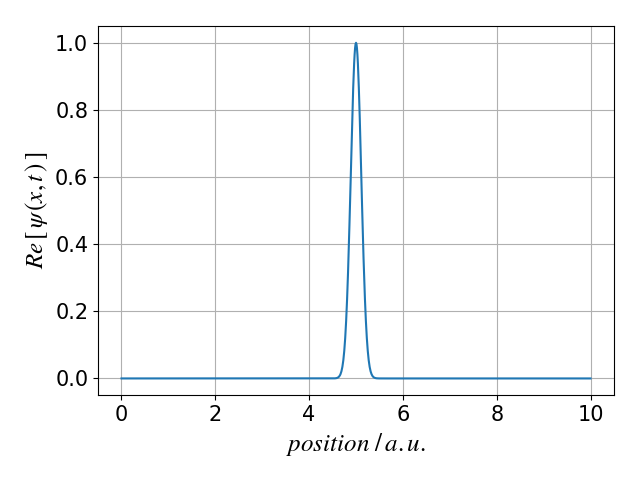

In [7]:
fig = plt.figure()
ax = fig.gca()

ax.plot(x_array, initial_wavefunction.real)
ax.set_xlabel(r'$position\,\,/\,a.u.$')
ax.set_ylabel(r'$Re\,[\,\psi\,(x,t\,)\,]$')

fig.tight_layout()

## Configure potential function (array)

In [8]:
## Set potential energy array in position representation
potential_energy_array = np.zeros(N_x)

<IPython.core.display.Javascript object>


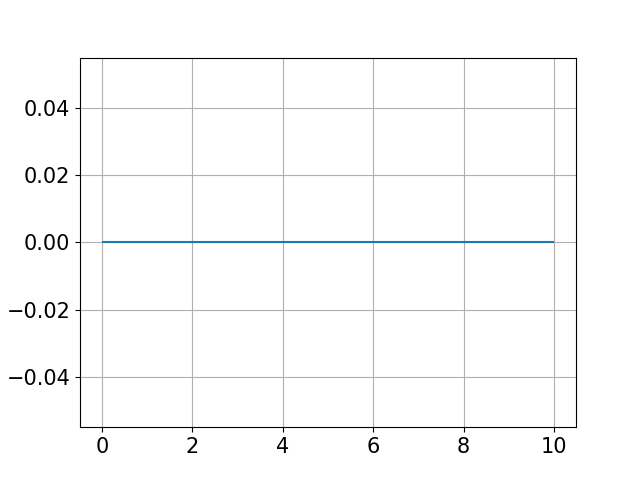

In [9]:
fig, ax = plt.subplots()
ax.plot(x_array, potential_energy_array)

# [ Construct Hamiltonian matrix ]

In [10]:
matrix_shape = [N_x, N_x]  # Think about why the matrix is N_x by N_x matrix

## Construct Kinetic Energy matrix (KE)

\begin{equation}
KE
\approx
-\frac{\hbar^2}{2m}
\frac{1}{\Delta{x}^2}
\begin{bmatrix}
    -2 & 1 & 0 & \dots & 0 & 0 & 0\\
    1 & -2 & 1 & \dots & 0 & 0 &0\\
    0 & 1 & -2 & \dots & 0 & 0 & 0\\
    \vdots & \vdots & \vdots & \vdots & \ddots & \ddots & \vdots \\
    0 & 0 & 0 & \dots & -2 & 1 & 0 \\
    0 & 0 & 0 & \dots & 1 & -2 & 1 \\
    0 & 0 & 0 & \dots & 0 & 1 & -2
\end{bmatrix}
\end{equation}

In [11]:
KE = np.zeros(matrix_shape)  # kinetic_energy_matrix

# Using atomic unit system
hbar = 1
m = 1

# Caclulate coefficient
coefficient = - hbar**2 / (2 * m) * 1.0 / (delta_x**2)

## Fill diagonal elements
diagonal_element = - 2.0 * coefficient
for i in range(N_x):
    j = i
    KE[i,j] = diagonal_element

## Fill offdiagonal elements
off_diagonal_element = 1.0 * coefficient
# Fill lower-offdiagonal
for i in range(1,N_x):
    j = i - 1
    KE[i,j] = off_diagonal_element

# Fill upper-offdiagonal
for i in range(0,N_x-1):
    j = i + 1
    KE[i,j] = off_diagonal_element
    
if boundary is 'periodic':
    ## Add '1' at upper right and lower left corner to represent the periodic boundary condition
    KE[0,N_x-1] = 1.0 * coefficient
    KE[N_x-1,0] = 1.0 * coefficient

## Construct potential energy matrix

In [12]:
PE = np.zeros(matrix_shape)  # potential_energy_matrix

# fill diagonal
for i in range(N_x):
    PE[i,i] = potential_energy_array[i]

## Construct Hamiltonian matrix

In [13]:
hamiltonian = KE + PE

# [ Obtain eigenenergy and eigenvectors ]
### We use numpy.linalg.eigh() function
### This funciton returns the eigenvalues and eigenvectors of a Hermitian matrix

In [14]:
eigen_values, eigen_vectors = np.linalg.eigh(hamiltonian)

# [ Time evolution ]

## Calculate components with energy eigenfunctions as basis
i.e. calculate **probability amplitude of each energy eigenfunctions**

In [15]:
psi_in_energy_representation = np.zeros(N_x, dtype=complex)

for idx in range(N_x):
    # Projection of 'test_psi' into each energy eigenvectors by using inner product
    # trapezoidal integration with box boundary condition is used for the inner product
    psi_in_energy_representation[idx] = (eigen_vectors[:,idx].conj() * initial_wavefunction).sum() * delta_x

#### Plot probability amplitude of each energy eigenfunctions

**[NOTE]** In finite dimension approximation, 
Hamiltonian operator is represented as n-by-n matrix
where 'n' denotes the dimension of vector space in which state vectors reside.
The eigenvalues of the Hamiltonian matrix are energy values 
which the system described by the Hamiltonian can have

<IPython.core.display.Javascript object>


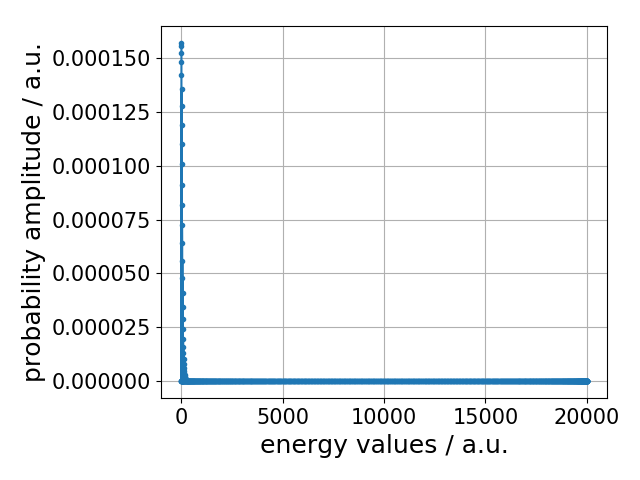

In [16]:
fig = plt.figure()
ax = fig.gca()

energy_values = eigen_values
probability_distribution = (psi_in_energy_representation.conj() * psi_in_energy_representation).real

ax.plot(energy_values, probability_distribution, '.-')

ax.set_xlabel('energy values / a.u.')
ax.set_ylabel('probability amplitude / a.u.')

fig.tight_layout()

## Define temporal grid

In [17]:
## Parameters for temporal grid on which the wavefunction will be calculated.
N_time = 300
delta_t = 0.005
t_0 = 0.0

# Define temporal grid array
t_k = t_0 + np.arange(N_time) * delta_t

## Single summation is sufficient to obtain time-dependent solution
\begin{equation}
\psi(x_{n},t_{k})=\sum_{j}{c_{j}\psi_{j}\left(x_{n}\right)exp\left({-iE_{j}t_{k}/\hbar}\right)}
\end{equation}

In [18]:
## Construct time dependent term array

Eigen_values, T_k = np.meshgrid(eigen_values, t_k, indexing='ij')

time_dependent_term = np.exp(-1.0j * Eigen_values * T_k)

In [19]:
# Sum up to get \psi(x,t)
# Here, einstein constraction function is used. Can also be seen as simple tensor network
psi_x_t = np.einsum(eigen_vectors, [0,1], psi_in_energy_representation, [1], time_dependent_term, [1,2])

In [20]:
# A callable function is defined
# This function will be used by 'Animate_1D' object to create an animation.
# This function should get an integer and return a 1D array to be plotted

def get_frame_data(i):
    return psi_x_t[:,i].real

# Move all parameters to the top

# [ ANIMATE! ]

In [21]:
from matplotlib.animation import FuncAnimation
from matplotlib.lines import Line2D

<IPython.core.display.Javascript object>


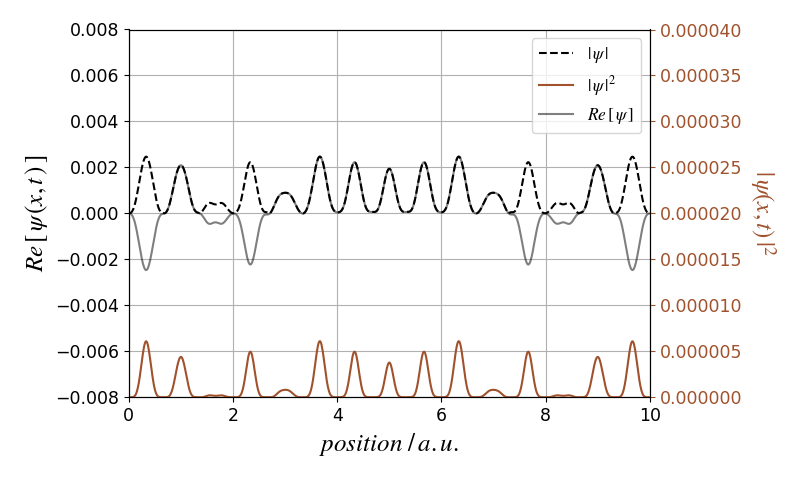

In [22]:
fig = plt.figure(figsize=(8,4.8))

square_color = 'sienna'

line_real = Line2D([],[],linestyle='-', marker='', color=(0,0,0,0.5))  # define an empty line
line_envelope = Line2D([],[],linestyle='--', marker='',color=(0,0,0,1), linewidth=1.5)
line_square = Line2D([],[],linestyle='-', marker='', color=square_color)

ax = fig.gca()  # 'get current axes' make an Axes object if there wasn't any.
ax_square = ax.twinx()

ax.add_line(line_real)
ax.add_line(line_envelope)
ax_square.add_line(line_square)

ax.set_xlim(x_min, x_max)
ylim_of_real_part = (-0.008, 0.008)
ax.set_ylim(*ylim_of_real_part)
ax.tick_params(labelsize='small')
ax.set_xlabel(r'$position\,\,/\,a.u.$')
ax.set_ylabel(r'$Re\,[\,\psi\,(x,t\,)\,]$')

# ylim_of_square = [np.sign(lim)*lim**2 for lim in ylim_of_real_part]
ax_square.set_ylim(0, 0.00004)
ax_square.set_ylabel(r'$\left|\,\psi(x,t)\,\right|^2$', rotation=270, va='bottom', color=square_color)
ax_square.tick_params(axis='y', colors=square_color, labelsize='small')
ax_square.grid(False)

ax.legend([line_envelope, line_square, line_real], 
          [r'$\left|\,\psi\,\right|$',r'$\left|\,\psi\,\right|^2$',r'$Re\,[\,\psi\,]$'],
         loc='upper right', fontsize='small')

fig.tight_layout()

x_plot = np.empty((N_x+2,))
x_plot[0], x_plot[-1] = x_min, x_max
x_plot[1:-1] = x_array

y_plot = np.empty((N_x+2,))
y_plot[0], y_plot[-1] = 0, 0  # zero-boundary condition (infinite potential well)

y_envelope = y_plot.copy()

y_square = y_plot.copy()

def update(i):
    y_plot[1:-1] = get_frame_data(i)
    line_real.set_data(x_plot, y_plot)
    
    y_envelope[:] = np.abs(y_plot)
    line_envelope.set_data(x_plot, y_envelope)
    
    y_square[:] = np.square(y_envelope)
    line_square.set_data(x_plot, y_square)
    
    return line_real, line_square

ani = FuncAnimation(fig, update, frames=N_time, blit=True)

### [NOTE] In order to run the following code install 'pillow' by `pip install pillow` at relevant terminal

In [23]:
from matplotlib.animation import PillowWriter

ani_writer = PillowWriter(fps=15)

In [24]:
ani_file_name = '{0}-boundary-gaussian-positive-k0-{1:.4}-x0-{2:.4}.gif'.format(boundary, k0, x0)
print(ani_file_name)

zero-boundary-gaussian-positive-k0-0.0-x0-5.0.gif


In [25]:
ani.save(ani_file_name, writer=ani_writer)